# Groupby and Arrest Data

In our merging exercises, we examined the relationship between county-level violent arrest totals and county-level drug arrest totals. In those exercises, you were given a dataset that provided you with county-level arrest totals. But that's not actually how the data is provided by the state of California. This week we will work with the *raw* California arrest data, which is not organized by county or even county-year. 



## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_groupby.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

### Exercise 1

Import the raw California arrest data from the State Attorney General's office. Please use [this link](https://github.com/nickeubank/MIDS_Data/blob/master/OnlineArrestData1980-2021.csv) (the original is here [here](https://openjustice.doj.ca.gov/data), but they keep updating it and I get tired of updating solutions, so... please use my copy!)

In [1]:
import pandas as pd

pd.options.mode.copy_on_write = True


url = "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/refs/heads/master/OnlineArrestData1980-2021.csv"
print("Loading from:", url)
data = pd.read_csv(url)

print("Original columns:", data.columns.tolist())

Loading from: https://media.githubusercontent.com/media/nickeubank/MIDS_Data/refs/heads/master/OnlineArrestData1980-2021.csv
Original columns: ['YEAR', 'GENDER', 'RACE', 'AGE_GROUP', 'COUNTY', 'VIOLENT', 'PROPERTY', 'F_DRUGOFF', 'F_SEXOFF', 'F_ALLOTHER', 'F_TOTAL', 'M_TOTAL', 'S_TOTAL']
Original columns: ['YEAR', 'GENDER', 'RACE', 'AGE_GROUP', 'COUNTY', 'VIOLENT', 'PROPERTY', 'F_DRUGOFF', 'F_SEXOFF', 'F_ALLOTHER', 'F_TOTAL', 'M_TOTAL', 'S_TOTAL']


## Learning the Group Structure of Your Data

### Exercise 2

What is the unit of observation for this dataset? In other words, when row zero says that there were 505 arrests for `VIOLENT` crimes, what exactly is that telling you—505 arrests in 1980? 505 arrests in Alameda County?

(Please answer in Markdown)

The unit of this data set is the aggregate crime statistics based on year, gender, race, age group and county.

### Testing Your Assumptions

It's important to be able to test whether the data you are working with really is organized the way you think it is, especially when working with groupby. Let's discuss how to check your answer to Exercise 2 with the `.duplicated()` method. 

Consider the following toy data:

In [2]:
import pandas as pd

df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            333333333,
            333333333,
        ],
        "second_column": ["a", "a", "a", "a", "b"],
    }
)
df

,social_security_numbers,second_column
0,111111111,a
1,222222222,a
2,222222222,a
3,333333333,a
4,333333333,b


If we want to see if there are any duplicate rows in the dataset, we can use the `.duplicated()` method:

In [3]:
df.duplicated()

0    False
1    False
2     True
3    False
4    False
dtype: bool

As you can see, `.duplicated()` looks at each row and returns `True` if it has seen the row it is looking at before. 

Notice that `.duplicted()` doesn't return `True` for *all* rows that look the same as another row in the data—it treats the first instance of a row as unique, and only tags *subsequent* repetitions as "duplicates" (You can change this behavior with the `keep` keyword argument if you want).

`.duplicated()` can also be used to test for rows that are duplicates in terms of a sub-set of columns. For example, `df.duplicated(["social_security_numbers"])` identifies rows with duplicate values of the variable `social_security_numbers`:

In [4]:
df.duplicated(["social_security_numbers"])

0    False
1    False
2     True
3    False
4     True
dtype: bool

Since `duplicated` is now only looking at `social_security_numbers` (not all values in a row), the last row is now a duplicate (because `333333333` is duplicated), where when we considered all columns, it was not a duplicate. 

### Testing with .duplicated()

`.duplicated()` can be paired with the `.any()` method to write `assert` tests to detect the presence of duplicates in our dataset and to validate our assumptions about whether certain variables uniquely identify observations in our data.

When you run `.any()` on an array of Booleans, it returns a single value of `True` if *any* entries are `True`, and a single value of `False` if *no* entries are `True`. (You can also use `.all()` to test if all entries are `False`).

Thus the command `df.duplicated(['social_security_numbers'])` will return `False` if `social_security_numbers` uniquely identifies every row in our dataset (since there are no duplicates)! But if there *are* any duplicates, it will return `True`:

In [5]:
df.duplicated(["social_security_numbers"]).any()

np.True_

So if I wanted a test that would raise an `Error` if it turned out that `social_security_numbers` *didn't* uniquely identify observations, I would combine that code with `assert not`:

```python
assert not df.duplicated(["social_security_numbers"]).any()

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In [20], line 1
----> 1 assert not df.duplicated(["social_security_numbers"]).any()

AssertionError: 
```

(which in this case raises an Error because `social_security_numbers` *isn't* unique!)

BTW, if this feels oddly familiar, that's probably because we talked about this same idea when discussing merging. A `1:1` merge is one in which the merging variables uniquely identify observations in both datasets.

### Exercise 3

Use `duplicated` to test if the variables *you* think uniquely identify rows in your data really do uniquely identify rows. If you were wrong, update your beliefs (and your code) until you have an `assert` statement that passes.

In [6]:
df.duplicated().any()

np.True_

### Exercise 4

Once you have a handle on how the data looks now, please **collapse the data** to be one observation per county-year-racial group. Store the number of rows in the resulting dataframe in your `results` dictionary under the key `"ex4_num_rows"`.

**Hint:** Think carefully about the most appropriate *aggregation function* (e.g., mean, median, sum, count) given the data we're working with!

**Hint 2:** When using `groupby`, I am a HUGE fan of the `as_index=False` keyword argument (e.g., `df.groupby("col1", as_index=False).mean()`). By default when you use groupby, pandas likes to make a new index out of the grouping columns. As you know, I HATE indices, and this keyword argument prevents pandas from this behavior. To illustrate:

In [7]:
data.columns = data.columns.str.strip().str.upper()

data = data.reset_index()

print("Cleaned columns:", data.columns.tolist())

group_cols = ["YEAR", "RACE", "COUNTY"]
agg_cols = [
    c
    for c in data.columns
    if c not in group_cols and pd.api.types.is_numeric_dtype(data[c])
]

df_collapsed = data.groupby(group_cols, as_index=False)[agg_cols].sum()

results = {}
results["ex4_num_rows"] = len(df_collapsed)

df_collapsed.head(), results

Cleaned columns: ['index', 'YEAR', 'GENDER', 'RACE', 'AGE_GROUP', 'COUNTY', 'VIOLENT', 'PROPERTY', 'F_DRUGOFF', 'F_SEXOFF', 'F_ALLOTHER', 'F_TOTAL', 'M_TOTAL', 'S_TOTAL']


(   YEAR   RACE               COUNTY  index  VIOLENT  PROPERTY  F_DRUGOFF  \
 0  1980  Black       Alameda County    174     2594      5138       1489   
 1  1980  Black         Butte County    910       32        33          5   
 2  1980  Black     Calaveras County    486        0         0          0   
 3  1980  Black        Colusa County    776        0         5          0   
 4  1980  Black  Contra Costa County   2370      720      1422        368   
 
    F_SEXOFF  F_ALLOTHER  F_TOTAL  M_TOTAL  S_TOTAL  
 0        94         541     9856    24081      555  
 1         0           7       77      139        0  
 2         0           0        0        7        0  
 3         0           0        5       13        0  
 4        24         257     2791     5201       40  ,
 {'ex4_num_rows': 9702})

### Exercise 5

You should notice that there are significantly fewer rows in the data now. Given your answer from 3, what groups were you *collapsing* in question 4 (in other words, which different groups were previously split out into separate rows but have now been aggregated into the same rows)?

We were collapsing across gender and age group.

Store the names of those variables **in a `list` in alphabetical order** in `results` as `"ex5_collapsed_vars"`.

In [8]:
results["ex5_collapsed_vars"] = ["AGE_GROUP", "GENDER"]

print(f"\nVariables that were collapsed: {results['ex5_collapsed_vars']}")
print("Explanation: These variables were in the original data but NOT in")
print("the grouping columns, so they were aggregated (summed) together.")


Variables that were collapsed: ['AGE_GROUP', 'GENDER']
Explanation: These variables were in the original data but NOT in
the grouping columns, so they were aggregated (summed) together.


## Racial Arrest Composition

The next question we want to ask is: does the racial composition of arrests in each county vary by arrest type? In other words, do Blacks, Hispanics, Whites, and Other make up substantially different portions of the people arrested for drug offenses and violent offenses?

To answer this question, we need to be able to say what proportion of all drug arrestees were Black/White/Hispanic/Other and what proportion of all violent arrestees were Black/White/Hispanic/Other *for each county and for each year*.

In trying to do this, we'll need to break the problem down into pieces, starting from our goal (these quantities) and working backwards.

### Exercise 6

To calculate the share of all drug and violent arrestees who come from each racial group, what quantities do we need? 

Expressed differently, what two variables (one for drug arrests, one for violent arrests) do we need to add to our data to it allow us to calculate the share of arrestees in each county-year that come from a given racial group?

Calculate these two variables (one variable for drug arrests, one for violent arrests). 

**Hint:** `transform` should probably make an appearance here.

In [9]:
cols_n = ["YEAR", "COUNTY"]
df_collapsed["T_DRUG"] = df_collapsed.groupby(cols_n)["F_DRUGOFF"].transform("sum")
df_collapsed["T_VIOL"] = df_collapsed.groupby(cols_n)["VIOLENT"].transform("sum")


df_collapsed

,YEAR,RACE,COUNTY,index,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,T_DRUG,T_VIOL
0,1980,Black,Alameda County,174,2594,5138,1489,94,541,9856,24081,555,3569,4504
1,1980,Black,Butte County,910,32,33,5,0,7,77,139,0,149,306
2,1980,Black,Calaveras County,486,0,0,0,0,0,0,7,0,83,52
3,1980,Black,Colusa County,776,0,5,0,0,0,5,13,0,9,28
4,1980,Black,Contra Costa County,2370,720,1422,368,24,257,2791,5201,40,1089,1596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9697,2021,White,Tulare County,1218149,524,407,195,10,413,1549,3368,31,635,2360
9698,2021,White,Tuolumne County,1218161,182,63,35,13,289,582,1393,2,44,229
9699,2021,White,Ventura County,1218173,574,372,308,13,672,1939,7509,18,752,1845
9700,2021,White,Yolo County,1218185,171,163,51,8,173,566,1051,0,92,480


**Hint:** This types of groupby manipulations are an easy place to do things wrong, so it's important to eye-ball your data to be sure you did things right! 

Take a look at the data for, say, Alameda County in 1980, and compare the values that you calculate above with what you get if you try to calculate those same numbers by hand using the raw data from Exercise 5?

### Exercise 7

Now calculate the share of violent and drug arrestees in each county and year from each racial group.

To ensure you're on the right track, store the share (between zero and one) of violent arrestees in Alameda County in 1980 who were Black as `ex7_alameda_1980_share_violent_arrestees_black`.

In [10]:
import numpy as np

# Calculate shares and handle NaN/inf values from division by zero
share_drug = df_collapsed["F_DRUGOFF"].astype(float) / df_collapsed["T_DRUG"].astype(float)
df_collapsed["SHARE_DRUG"] = share_drug.replace([np.inf, -np.inf], 0).fillna(0)

share_viol = df_collapsed["VIOLENT"].astype(float) / df_collapsed["T_VIOL"].astype(float)
df_collapsed["SHARE_VIOL"] = share_viol.replace([np.inf, -np.inf], 0).fillna(0)

In [11]:
ex7_alameda_1980_share_violent_arrestees_black = df_collapsed.loc[
    (df_collapsed["YEAR"] == 1980)
    & (df_collapsed["RACE"] == "Black")
    & (df_collapsed["COUNTY"] == "Alameda County"),
    "SHARE_VIOL",
].values[0]


results["ex7_alameda_1980_share_violent_arrestees_black"] = (
    ex7_alameda_1980_share_violent_arrestees_black
)

print(f"\nShare of violent arrestees in Alameda County 1980 who were Black:")
print(
    f"{ex7_alameda_1980_share_violent_arrestees_black:.6f} ({ex7_alameda_1980_share_violent_arrestees_black*100:.2f}%)"
)


Share of violent arrestees in Alameda County 1980 who were Black:
0.575933 (57.59%)


### Exercise 8

We're about to start studying this data by plotting the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. But the moment where you finish your data manipulations and are about to start you data analysis is a *great* time to just make sure everything in your data looks good. Let's run a few checks:

- Are your values of the share of felony arrestees who were arrested for violent crimes sensible?
- You're about to analyze the data using only the rows for the Black racial group. How many unique counties are there with data for Black arrestees? How many for White arrestees? Do you remember how many counties there are in CA (google is your friend if not!)?

Include assert statements to check all these features of your data.

(Reminder: the autograder will only work if you are entire notebook runs without errors.)

If you encounter any problems, make sure you understand why they are happening, and fix them (if a fix is appropriate!).

In [12]:
black_counties = df_collapsed["COUNTY"][df_collapsed["RACE"] == "Black"].nunique()
white_counties = df_collapsed["COUNTY"][df_collapsed["RACE"] == "White"].nunique()
hispanic_counties = df_collapsed["COUNTY"][df_collapsed["RACE"] == "Hispanic"].nunique()
other_counties = df_collapsed["COUNTY"][df_collapsed["RACE"] == "Other"].nunique()

print(f"\nNumber of unique counties by race:")
print(f"  Black: {black_counties}")
print(f"  White: {white_counties}")
print(f"  Hispanic: {hispanic_counties}")
print(f"  Other: {other_counties}")

# Assert they're all equal
assert black_counties == white_counties == hispanic_counties == other_counties
print("\n✓ All racial groups have the same number of counties")

# Check share values are sensible (between 0 and 1)
assert (df_collapsed["SHARE_DRUG"] >= 0).all() and (
    df_collapsed["SHARE_DRUG"] <= 1
).all()
assert (df_collapsed["SHARE_VIOL"] >= 0).all() and (
    df_collapsed["SHARE_VIOL"] <= 1
).all()
print("✓ All share values are between 0 and 1")


Number of unique counties by race:
  Black: 58
  White: 58
  Hispanic: 58
  Other: 58

✓ All racial groups have the same number of counties
✓ All share values are between 0 and 1


### Exercise 9

Now check to see if you have the same number of counties *in each year for each racial group*.

Can you figure out why there aren't? (Hint: this isn't trivial to figure out! You'll probably have to do some detective work, and even then you'll have to make a bit of a "best guess" at what's going on!)

In [13]:
county_counts = df_collapsed.groupby(["YEAR", "RACE"])["COUNTY"].nunique().reset_index()
county_counts_pivot = county_counts.pivot(index="YEAR", columns="RACE", values="COUNTY")

print("\nNumber of counties with data for each race by year (sample):")
print(county_counts_pivot.head(40))


Number of counties with data for each race by year (sample):
RACE  Black  Hispanic  Other  White
YEAR                               
1980     55        57     58     58
1981     55        57     58     58
1982     55        57     58     58
1983     57        58     58     58
1984     55        57     58     58
1985     57        57     58     58
1986     55        57     58     58
1987     55        58     58     58
1988     57        58     58     58
1989     58        58     58     58
1990     56        58     58     58
1991     57        58     58     58
1992     57        58     58     58
1993     57        58     58     58
1994     58        58     58     58
1995     57        58     58     58
1996     57        58     58     58
1997     57        58     58     58
1998     58        58     58     58
1999     58        58     58     58
2000     58        58     57     58
2001     57        58     58     58
2002     58        58     58     58
2003     57        58     58     58
20

Perhaps there were no recordings for those years.

### Exercise 10

Once you think you have a theory of the case, fix the problem. Again, this will NOT be trivial.

In [14]:
from itertools import product

# Create complete index of all combinations
all_years = df_collapsed["YEAR"].unique()
all_races = df_collapsed["RACE"].unique()
all_counties = df_collapsed["COUNTY"].unique()

complete_index = pd.DataFrame(
    list(product(all_years, all_races, all_counties)),
    columns=["YEAR", "RACE", "COUNTY"],
)

print(complete_index)

# Merge and fill missing values with 0
df_collapsed = complete_index.merge(
    df_collapsed, on=["YEAR", "RACE", "COUNTY"], how="left"
).fillna(0)

# Recalculate totals and shares
df_collapsed["T_DRUG"] = df_collapsed.groupby(["YEAR", "COUNTY"])[
    "F_DRUGOFF"
].transform("sum")
df_collapsed["T_VIOL"] = df_collapsed.groupby(["YEAR", "COUNTY"])["VIOLENT"].transform(
    "sum"
)

# Recalculate shares with float division
df_collapsed["SHARE_DRUG"] = df_collapsed["F_DRUGOFF"].astype(float) / df_collapsed[
    "T_DRUG"
].astype(float)
df_collapsed["SHARE_VIOL"] = df_collapsed["VIOLENT"].astype(float) / df_collapsed[
    "T_VIOL"
].astype(float)

# Verify fix worked
county_counts = df_collapsed.groupby(["YEAR", "RACE"])["COUNTY"].nunique().reset_index()
print(county_counts.pivot(index="YEAR", columns="RACE", values="COUNTY").head())

      YEAR   RACE               COUNTY
0     1980  Black       Alameda County
1     1980  Black         Butte County
2     1980  Black     Calaveras County
3     1980  Black        Colusa County
4     1980  Black  Contra Costa County
...    ...    ...                  ...
9739  2021  White          Yolo County
9740  2021  White          Yuba County
9741  2021  White        Amador County
9742  2021  White        Sierra County
9743  2021  White        Alpine County

[9744 rows x 3 columns]
RACE  Black  Hispanic  Other  White
YEAR                               
1980     58        58     58     58
1981     58        58     58     58
1982     58        58     58     58
1983     58        58     58     58
1984     58        58     58     58


### Exercise 11

Now that you have corrected your problem, averaging over the values for each county-year, calculate the average share of drug arrestees who are Black and the average share of drug arrestees who are White. Store the results as `"ex11_white_drug_share"` and `"ex11_black_drug_share"`.

In [22]:
# Only calculate mean for county-years where this racial group had drug arrests
ex11_black_drug_share = df_collapsed[
    (df_collapsed["RACE"] == "Black") & (df_collapsed["F_DRUGOFF"] > 0)
]["SHARE_DRUG"].mean()

ex11_white_drug_share = df_collapsed[
    (df_collapsed["RACE"] == "White") & (df_collapsed["F_DRUGOFF"] > 0)
]["SHARE_DRUG"].mean()

results["ex11_black_drug_share"] = ex11_black_drug_share

results["ex11_white_drug_share"] = ex11_white_drug_share

In [23]:
print(f"ex11_black_drug_share: {ex11_black_drug_share}")
print(f"ex11_white_drug_share: {ex11_white_drug_share}")

ex11_black_drug_share: 0.1110633752434145
ex11_white_drug_share: 0.6213365249523103


### Exercise 12

Plot the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. Do they look proportionate? Answer in text here.

Do Black arrestees make up a greater share of violent arrestees, or a greater share of drug arrestees? Store you answer as `"greater violent"`, or `"greater drug"` in `"ex12_proportionate"`.

**Hint:** You can add a 45 degree reference line by making a dummy dataset with one point at 0,0 and one point at a location near the top of your data (e.g. 0.7, 0.7). Without a reference line it's VERY hard to be sure if how your points relate to proportionality.

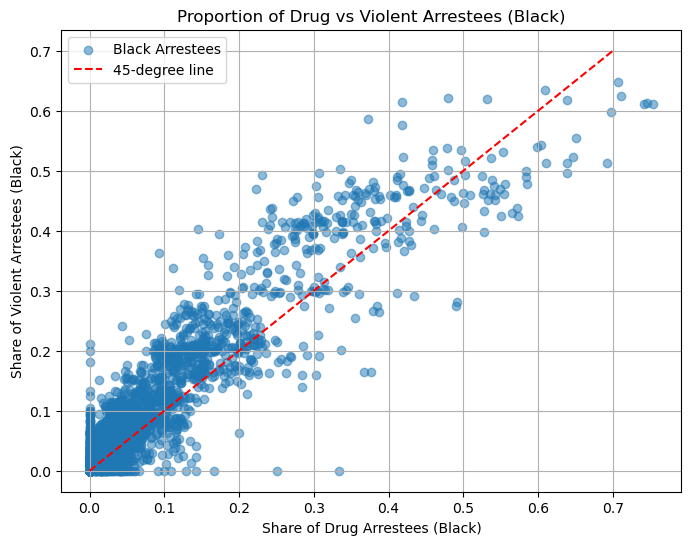

{'ex4_num_rows': 9702,
 'ex5_collapsed_vars': ['AGE_GROUP', 'GENDER'],
 'ex7_alameda_1980_share_violent_arrestees_black': np.float64(0.5759325044404974),
 'ex11_black_drug_share': np.float64(0.09209576177591779),
 'ex11_white_drug_share': np.float64(0.620058054736359),
 'ex12_proportionate': 'greater violent'}

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.scatter(
    df_collapsed[df_collapsed["RACE"] == "Black"]["SHARE_DRUG"],
    df_collapsed[df_collapsed["RACE"] == "Black"]["SHARE_VIOL"],
    alpha=0.5,
    label="Black Arrestees",
)

plt.plot([0, 0.7], [0, 0.7], color="red", linestyle="--", label="45-degree line")

plt.xlabel("Share of Drug Arrestees (Black)")
plt.ylabel("Share of Violent Arrestees (Black)")
plt.title("Proportion of Drug vs Violent Arrestees (Black)")
plt.legend()
plt.grid(True)
plt.show()

if (
    ex11_black_drug_share
    > df_collapsed[df_collapsed["RACE"] == "Black"]["SHARE_VIOL"].mean()
):
    results["ex12_proportionate"] = "greater drug"
else:
    results["ex12_proportionate"] = "greater violent"

results

(A quick note of warning on interpretation: these results can tell you whether Black Californians make up a larger proportion of *arrests* for certain types of crimes, not whether they make up a larger proportion of people who *commit* a give type of crime! Those *might* be the same, but they might not... this data just can't answer that question.)

In [17]:
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}

results

{'ex4_num_rows': 9702,
 'ex5_collapsed_vars': ['AGE_GROUP', 'GENDER'],
 'ex7_alameda_1980_share_violent_arrestees_black': np.float64(0.5759325044404974),
 'ex11_black_drug_share': np.float64(0.09209576177591779),
 'ex11_white_drug_share': np.float64(0.620058054736359),
 'ex12_proportionate': 'greater violent'}